<a href="https://colab.research.google.com/github/abhinavdayal/EIP_Session5/blob/master/Copy_of_simplefunctional_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 2.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path
import time, math
import tensorflow as tf
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

TensorFlow 2.x selected.


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
df.loc[df.bodypose=="Back", "emotion"] = "Neutral" # correct wrong annotation
df[(df.bodypose=="Back") & (df.emotion!='Neutral')] # verify

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, shuffle=True, random_state=40)
print(train_df.shape, val_df.shape)
len_train = train_df.shape[0]
len_test = val_df.shape[0] 

(11537, 28) (2036, 28)


In [0]:
mu, std = (np.array([41.33479712, 41.57640031, 46.66141538]), np.array([63.9889454,  64.6502506,  69.85974087])) # copied from another sheet precalculated

In [0]:
# we will avoid this for now
"""
o = train_df[(train_df.emotion!=2)]
for i in range(5):train_df = train_df.append(o)
o = train_df[(train_df.bodypose==0)]
train_df = train_df.append(o)
o = train_df[(train_df.bodypose!=1)]
train_df = train_df.append(o)
o = train_df[(train_df.age==4) | (train_df.age==3)]
train_df = train_df.append(o)
o = train_df[(train_df.carryingbag==1)]
for i in range(2): train_df = train_df.append(o)
o = train_df[(train_df.weight==1) | (train_df.weight==3)]
for i in range(2): train_df = train_df.append(o)
"""
train_df.describe()

,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
count,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000,11537.000000
mean,0.437722,0.562278,0.553523,0.166768,0.279709,0.179943,0.399151,0.255612,0.109474,0.055820,0.633787,0.065008,0.238450,0.062755,0.338476,0.097686,0.563838,0.371327,0.184017,0.444656,0.106440,0.114154,0.721938,0.057467,0.163301,0.618445,0.218254
std,0.496128,0.496128,0.497149,0.372785,0.448876,0.384156,0.489745,0.436224,0.312246,0.229585,0.481790,0.246551,0.426154,0.242532,0.473212,0.296902,0.495929,0.483181,0.387515,0.496949,0.308414,0.318013,0.448063,0.232743,0.369656,0.485789,0.413079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/11375.jpg,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
1,resized/4017.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
2,resized/1067.jpg,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0
3,resized/989.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
4,resized/557.jpg,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1


In [0]:
class image_processor():
    def rolldie(self, p):
      p_1 = np.random.rand()
      if p_1 > p:
          return False
      return True

    def adjust(self, start, span, dim_len):
      if start + span > dim_len:
          if start-span >= 0:
            start = start-span
          else:
            if self.rolldie(0.5):
              start -= (start+span) - dim_len
            else:
              start = 0

      return start

    def region(self, img_w, img_h, s_l, s_h, r_1=1, r_2=1):
        s = np.random.uniform(s_l, s_h) * img_h * img_w #area to cutout
        #print(s)
        if r_1==1 and r_2==1:
          r = img_h/img_w # use image aspect only
        else:
          r = np.random.uniform(r_1, r_2) # aspect ratio
        w = int(np.sqrt(s / r)) # width of cutout
        h = int(np.sqrt(s * r)) # height of cutout
        
        left = self.adjust(np.random.randint(0, img_w), w, img_w) # start
        top = self.adjust(np.random.randint(0, img_h), h, img_h) # end

        #print(left, top, left+w, top+h)
        return (left, top, w, h)

    

    def cutout(self, input_img, p=0.5, s_l=0.04, s_h=0.08, r_1=0.3, r_2=1/0.3):
        if self.rolldie(p):
          return input_img

        avg_color = np.array([0,0,0]).astype('float32')
        img_h, img_w, img_c = input_img.shape

        left, top, w, h = self.region(img_w, img_h, s_l, s_h, r_1, r_2)

        #print(top, left, h, w)
        input_img[top:top + h, left:left + w, :] = avg_color

        return input_img

    def zoom(self, input_img, p=0.5, s_l=0.75, s_h=0.95):
        if self.rolldie(p):
          return input_img
        img_h, img_w, img_c = input_img.shape

        left, top, w, h = self.region(img_w, img_h, s_l, s_h)

        # crop and resize
        return  cv2.resize(input_img[top:top + h, left:left + w, :], (img_h, img_w), cv2.INTER_CUBIC)



In [0]:
class PersonDataGenerator(tf.keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, train_mean, train_std, batch_size=32, shuffle=True, training=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.train_mean = train_mean
        self.train_std = train_std
        self.training = training
        self.imp = image_processor()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = []
        for image in [cv2.imread(item["image_path"]).astype('float32') for _, item in items.iterrows()]:
          
          # augment for training but not for test
          if self.training:
            image = self.imp.cutout(image)
            image = self.imp.zoom(image)
            image = tf.image.random_brightness(image, max_delta=0.3)
            image = tf.image.random_flip_left_right(image) # horizontal flipping

          # normalize
          image = ((image-self.train_mean)/self.train_std)


            # TODO: try other types of augmentation as well
          images.append(image)


        target = {
            "gender_output": tf.convert_to_tensor(items[_gender_cols_].values, np.int32),
            "image_quality_output": tf.convert_to_tensor(items[_imagequality_cols_].values, np.int32),
            "age_output": tf.convert_to_tensor(items[_age_cols_].values, np.int32),
            "weight_output": tf.convert_to_tensor(items[_weight_cols_].values, np.int32),
            "bag_output": tf.convert_to_tensor(items[_carryingbag_cols_].values, np.int32),
            "pose_output": tf.convert_to_tensor(items[_bodypose_cols_].values, np.int32),
            "footwear_output": tf.convert_to_tensor(items[_footwear_cols_].values, np.int32),
            "emotion_output": tf.convert_to_tensor(items[_emotion_cols_].values, np.int32),
        }

        images = np.stack(images, axis=0)
        return tf.convert_to_tensor(images, np.float32), target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        # since we have already shuffled, we want to send all images in every batch
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
BATCH_SIZE = 32 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE =  0.01#@param {type:"number"}
WEIGHT_DECAY = 9e-4 #@param {type:"number"}
EPOCHS = 10 #@param {type:"integer"}

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, mu, std, batch_size=BATCH_SIZE)
test_gen = PersonDataGenerator(val_df, mu, std, batch_size=64, shuffle=False, training=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
def conv_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True,
                 separable = True):
    """
    TODO: add dropouts facility as well here
    """
    if separable:
      conv = tf.keras.layers.SeparableConv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    else:
      conv = tf.keras.layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = tf.keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = tf.keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = tf.keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = tf.keras.layers.Activation(activation)(x)
        x = conv(x)
    return x


In [0]:
def simpleModel(num_units, input_shape=(224, 224, 3)):
  inputs = tf.keras.Input(shape=input_shape)
  x = conv_layer(inputs = inputs, num_filters=32)
  x = conv_layer(inputs=x, num_filters=32)
  x = conv_layer(inputs=x, num_filters=32)
  x = tf.keras.layers.MaxPooling2D()(x) #112x112

  x = conv_layer(inputs=x, num_filters=64)
  x = conv_layer(inputs=x, num_filters=64)
  x = tf.keras.layers.MaxPooling2D()(x) #56x56

  x = conv_layer(inputs=x, num_filters=128)
  x = conv_layer(inputs=x, num_filters=128)
  x = tf.keras.layers.MaxPooling2D()(x) #28x28

  outputs = []
  for key in num_units:
    y = conv_layer(inputs=x, num_filters=256)
    y = conv_layer(inputs=y, num_filters=256)
    y = tf.keras.layers.MaxPooling2D()(y) #14x14

    y = conv_layer(inputs=y, num_filters=512)
    y = conv_layer(inputs=y, num_filters=512)
    y = tf.keras.layers.MaxPooling2D()(y) #7x7

    y = tf.keras.layers.GlobalAveragePooling2D()(y) #try globalmax as well
    outputs.append(tf.keras.layers.Dense(num_units[key], activation='softmax', use_bias=False, name = key+'_output', kernel_initializer='he_normal')(y))

  # Instantiate model.
  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [0]:
model = simpleModel(num_units)

In [0]:
class CyclicLR(tf.keras.callbacks.Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

In [0]:
#CLR = CyclicLR(base_lr=0.00001, max_lr=0.02, step_size=2000., mode='triangular')

# global_step/batches_per_epoch will be < 1 for first epoch per batch and between 1-2 for second and so on.
lr_func = lambda: 0.001
losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy"
}

# can try proportional to number of classes weights. So one with max classes has max weight and so on.
loss_weights = {
 	"gender_output": np.float32(1.0),
 	"image_quality_output": np.float32(1.0),
 	"age_output": np.float32(1.0),
 	"weight_output": np.float32(1.0),
  "bag_output": np.float32(1.0),
  "footwear_output": np.float32(1.0),
  "emotion_output": np.float32(1.0),
  "pose_output": np.float32(1.0)
}

model.compile(loss=losses, loss_weights=loss_weights, optimizer=tf.keras.optimizers.SGD(0.001, momentum=MOMENTUM, nesterov=True), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 224, 224, 32) 155         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

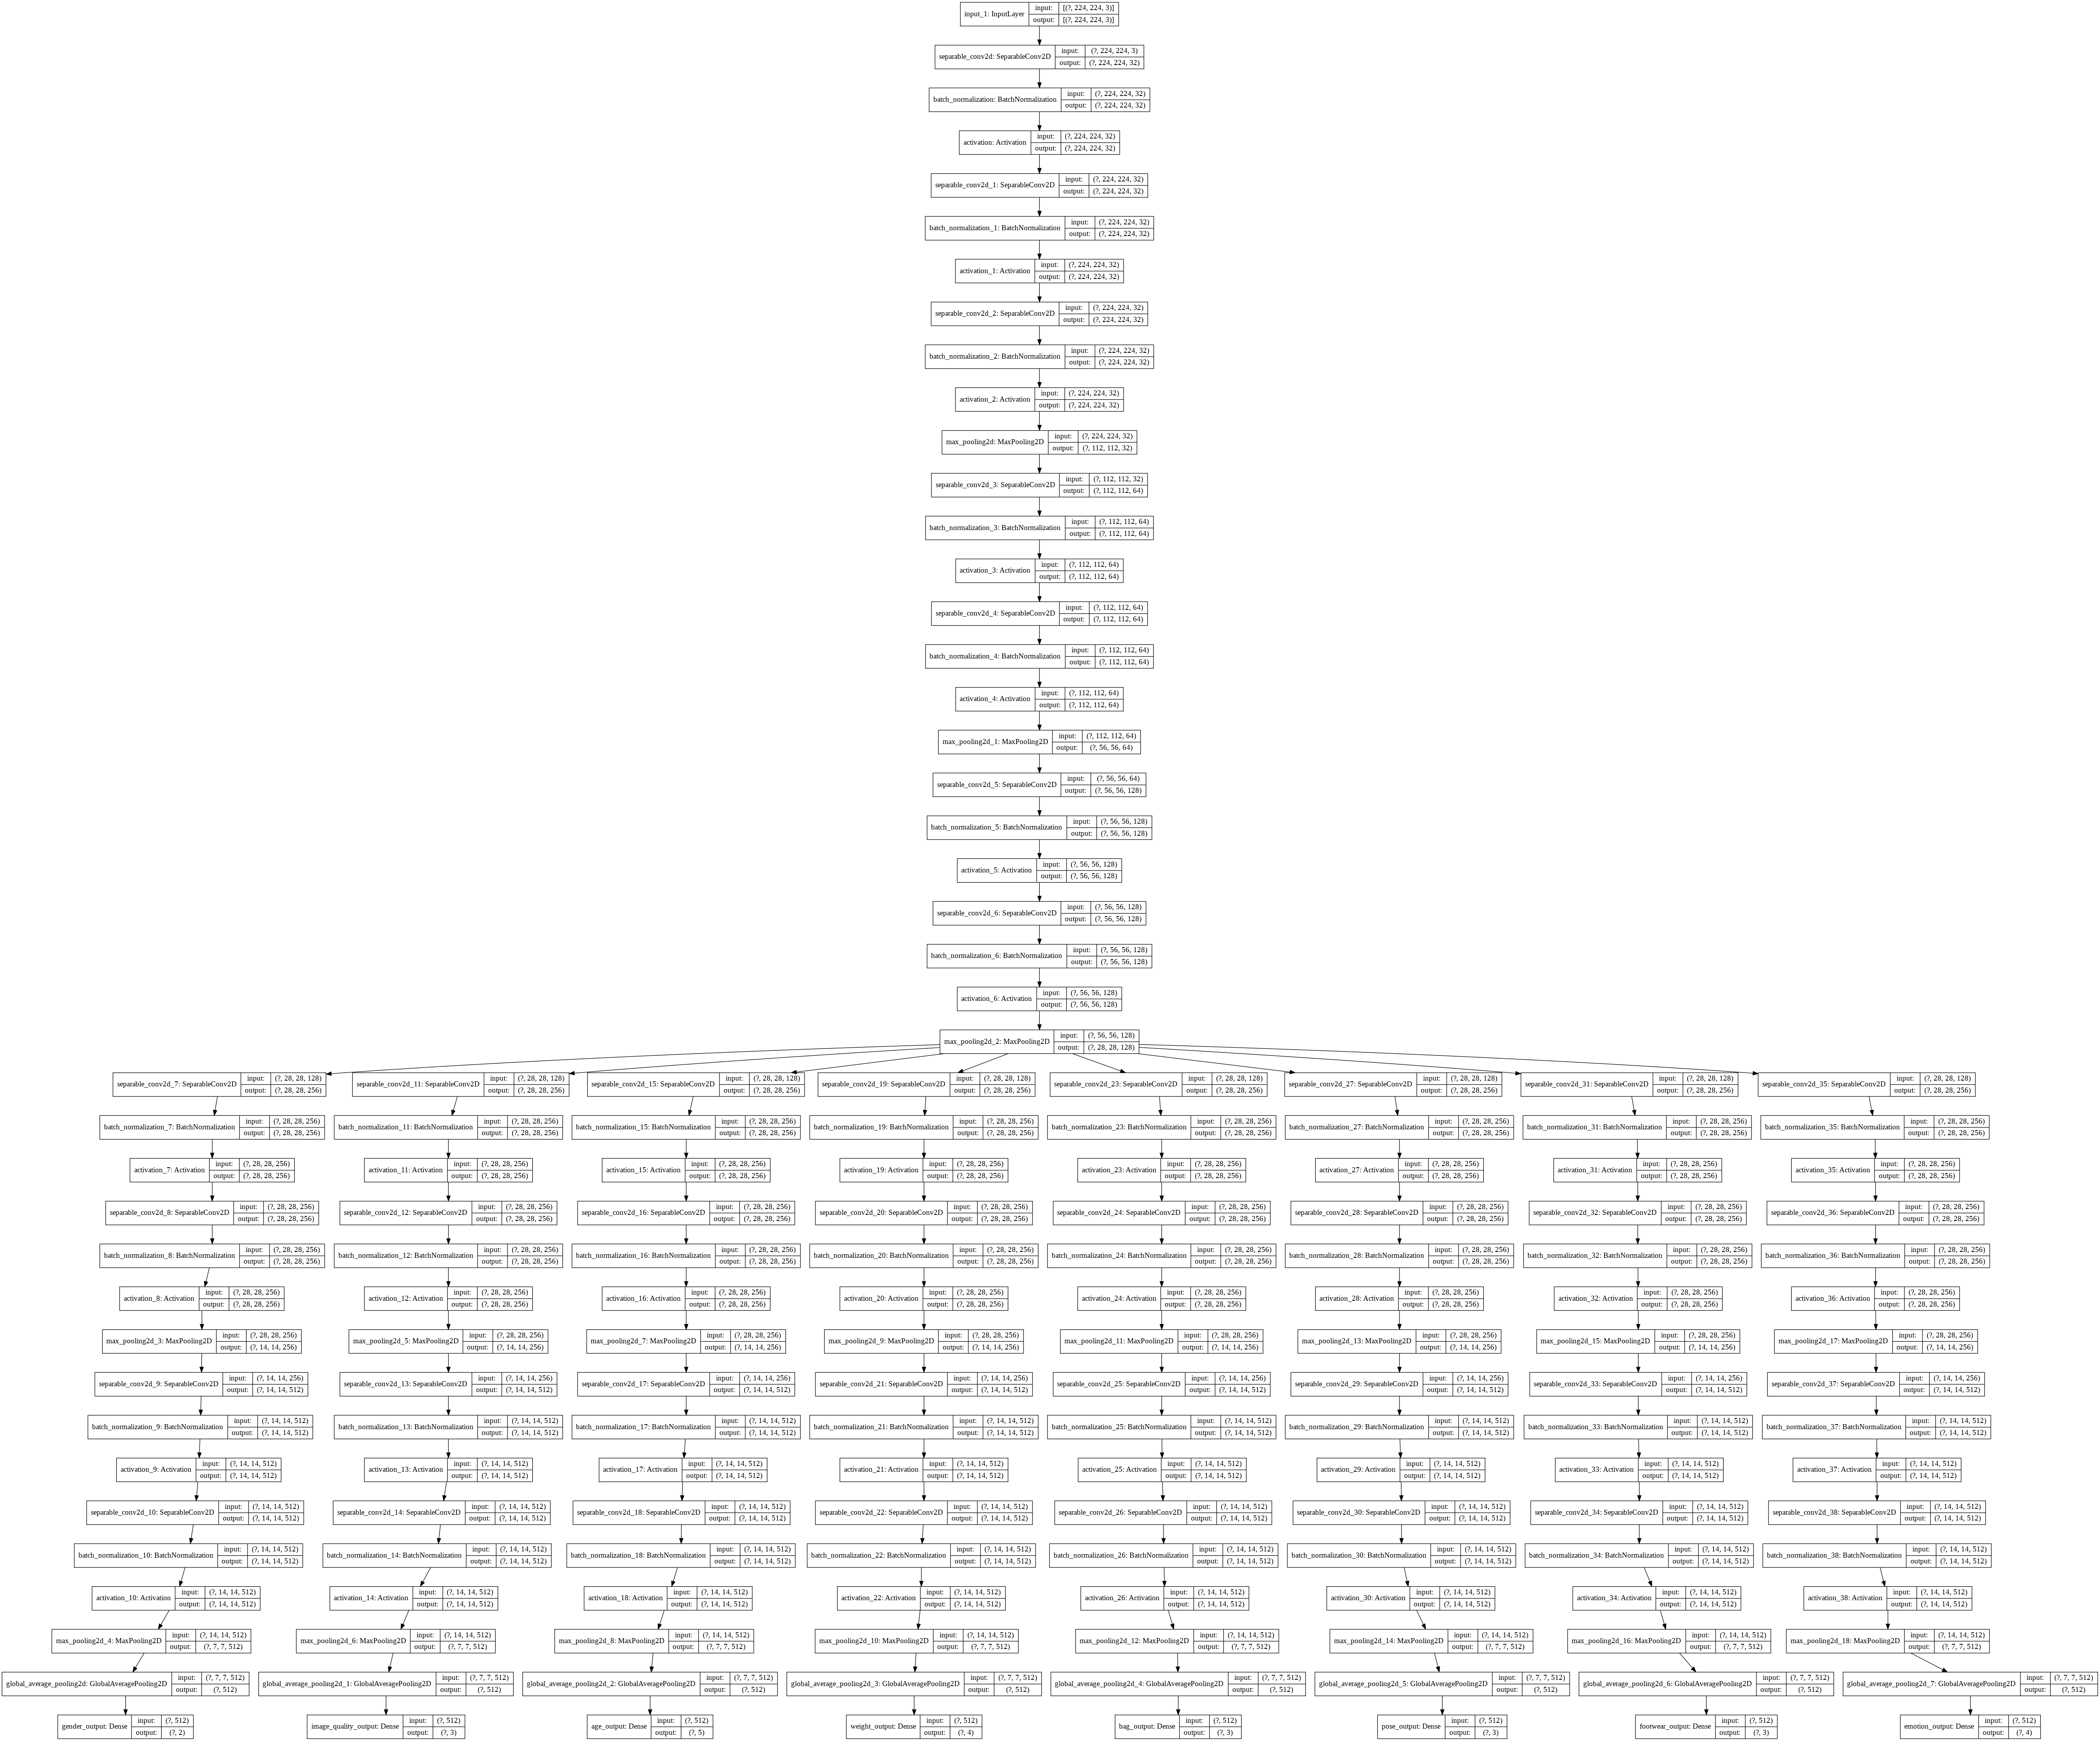

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
history = model.fit(x=train_gen, epochs=EPOCHS, verbose=1, validation_data=test_gen)

  {'gender_output': '...', 'image_quality_output': '...', 'age_output': '...', 'weight_output': '...', 'bag_output': '...', 'pose_output': '...', 'footwear_output': '...', 'emotion_output': '...'}
    to  
  ['...', '...', '...', '...', '...', '...', '...', '...']
  {'gender_output': '...', 'image_quality_output': '...', 'age_output': '...', 'weight_output': '...', 'bag_output': '...', 'pose_output': '...', 'footwear_output': '...', 'emotion_output': '...'}
    to  
  ['...', '...', '...', '...', '...', '...', '...', '...']
Train for 360 steps, validate for 31 steps
Epoch 1/10
140/360 [==========>...................] - ETA: 5:22 - loss: 7.9196 - gender_output_loss: 0.6807 - image_quality_output_loss: 0.9597 - age_output_loss: 1.4440 - weight_output_loss: 1.0194 - bag_output_loss: 0.9180 - pose_output_loss: 0.9490 - footwear_output_loss: 0.9978 - emotion_output_loss: 0.9511 - gender_output_accuracy: 0.5670 - image_quality_output_accuracy: 0.5478 - age_output_accuracy: 0.3864 - weight_ou